Initialisation 

In [1]:

import nbconvert

import pandas as pd
import csv
import math
import networkx as nx 
import heapq
import random 
# numpy pour dijkstra 
import numpy as np
from numpy import Inf

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj

import tkinter
#import os
#import flightradar24

In [75]:
#pip install voila
# pip install networkx
# pip install pyproj


## Regles de codage 


In [3]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [4]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [5]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [6]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

#dict_aeroports['CDG']

In [7]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

#dict_pays

In [8]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [9]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [10]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

def Sqr(a):
    return a*a

def Dist(x1,y1,x2,y2):
    return math.sqrt((y2-y1)**2+(x2-x1)**2)

In [11]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [12]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
        
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
            
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

# Fonctions -- Correspondance 

In [13]:
def correspondanceAirport(code1 : str, code2 : str):
    '''
    fonction qui filtre le df_vols pour obtenir les correspondances
    retour : list des airports codes 
    '''
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [14]:
def memeContinent(str_air1, str_air2):
    '''
    fonction qui retourne vrai si les deux sont sur le meme continent 
    et faux sinon
    '''
    c1 = dict_aeroports[str_air1]['Country']
    c2 = dict_aeroports[str_air2]['Country']
    
    return c1 == c2
    

def nettoyageList(str_list, str_airStart, str_airEnd):
    '''
    fonction qui supprimer les occurences dans le liste qui ne sont pas sur le 
    meme continent que les airport de depart et d'arrive . 
    '''
    
    if memeContinent(str_airStart, str_airEnd):
        #print('Les airports sont sur le même continent ')
        compteur = 0 ; 
        for element in str_list:
            if not memeContinent(str_airStart, element):
                str_list.remove(element)
                compteur = compteur + 1 
    
    #print('On a enleve {c} airports du list'.format(c = compteur))
    return str_list  
    

In [15]:
def creationEdgesConnection(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str, list_connections_nettoye):
    '''
    fonction qui genere des edges pour notre graphe avec les weights. On appele seulement cette
    focntion si on a le list_connections (qui sont les airports entre code1 et code2)
    retour : list_ref (qui a les index qui corresponds au nodes du graph)
    '''
        
    # pour gerer les correspondances 
    if list_reference.count(code1) == 0: 
        list_reference.append(code1)
        graphe.add_node(list_reference.index(code1))   
    if list_reference.count(code2) == 0: 
        list_reference.append(code2)
        graphe.add_node(list_reference.index(code1))
    
    for i in list_connections_nettoye :
        if list_reference.count(i) == 0 : 
            list_reference.append(i)   
            graphe.add_node(list_reference.index(i))  
    
    index1 = list_reference.index(code1) 
    index2 = list_reference.index(code2)
    
    list_edges = list(map(lambda x :
        (index1, list_reference.index(x), int(DistGrandCercleICAO(code1, x))),
        list_connections_nettoye))
    
    list_edges.extend(list(map(lambda y : 
        (list_reference.index(y), index2, int(DistGrandCercleICAO(y, code2))),
        list_connections_nettoye)))
   
   
    graphe.add_weighted_edges_from(list_edges)
    return list_reference

In [16]:
def creationEdgesAucunConnection(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    print(code1, code2)
    posCoteStart = df_vols[df_vols['Depart'] == code1]['Depart'].to_list()
    posCoteEnd = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()
    
    if posCoteStart == []: print('Dans notre database, il y a pas des vols qui part de {} .'.format(code1)) ; return False
    if posCoteEnd == []: print('Dans notre database, il y a pas des vols qui arrive sur {} .'.format(code2)); return False
    
    # des le moment que il trouve une chemin pour reliee les deux airports il le fait 
    for i_code in posCoteStart:
        for j_code in posCoteEnd: 
            # verifie si on a une connection 
            tmp = correspondanceAirport(i_code, j_code)
            # si on a une conenction 
            if len(tmp) > 0 :
                # on ajoute les premiere elements 
                list_reference.extend([code1, code2, i_code, j_code])
                edgeStart = (list_reference.index(code1), list_reference.index(i_code), int(DistGrandCercleICAO(code1, i_code)))
                edgeEnd = (list_reference.index(j_code), list_reference.index(code2), int(DistGrandCercleICAO(j_code, code2)))
                
                graphe.add_weighted_edges_from([edgeStart, edgeEnd])
                return creationEdgesConnection(graphe, list_reference, i_code, j_code, tmp)
                 
            
    print('Aucun possiblite pour relie des airports avec trois correspondances (qui est notre max predifini')

In [17]:
def creationEdges(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    list_connections = correspondanceAirport(code1, code2)
    list_connections_nettoye = list_connections
    
    if(len(list_connections) > 0 ):
      return creationEdgesConnection(graphe, list_reference, code1, code2, list_connections_nettoye)
    else :
        return print("let op functie"); creationEdgesAucunConnection(graphe, list_reference, code1, code2)

In [18]:
def dessinerGraphe(graphe, weighted : bool = False):
    fig = plt.figure(); 
    fig.set_size_inches(15, 15)
    fig.patch.set_facecolor('white')
 
    pos = nx.fruchterman_reingold_layout(graphe)
    nx.draw_networkx_nodes(graphe, pos, node_size = 200)
    nx.draw_networkx_edges(graphe,pos, edgelist= graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(graphe, pos)
    plt.autoscale()
   
    if(weighted): nx.draw_networkx_edge_labels(graphe, pos) # afficher le weight 

    plt.show()

In [19]:
def dijkstra(graphe : nx.Graph, start : int, end : int):
    '''
        fonction qui utilise l'algorithme de Dijkstra pour calcule le plus court
        chemin et calcule le distance
        retour \: dict{\'distance\' : ... , \'path\' : ...}
    '''
    tmp1 = nx.dijkstra_path(graphe, start,end)
    dist = nx.dijkstra_path_length(graphe, start, end)
        
    return {'distance' : dist, 'path' : tmp1}

In [20]:
def nombreDeCorrespondances(g : nx.Graph, codeStart, codeFin):
    listRetour = creationEdges(g, [], codeStart, codeFin)
    ## was not  
    if listRetour == [] : 
        
        print('check in nombreDeCorrespondance Edges : ', len(listRetour), g.number_of_edges())
        
        print('check in nombreDeCorrespondance: ', len(listRetour), g.number_of_nodes())
            
        if g.has_edge(listRetour.index(codeStart), listRetour.index(codeFin)): g.remove_edge(listRetour.index(codeStart), listRetour.index(codeFin))
        if g.has_edge(listRetour.index(codeFin), listRetour.index(codeStart)): g.remove_edge(listRetour.index(codeFin), listRetour.index(codeStart))
        
        return listRetour

    return listRetour

In [21]:
def traitementRequest(aeroport_start : str, aeroport_fin : str, g : nx.Graph = nx.Graph()):
    '''
        fonction qui fait le creation de graphe et qui transofrme les nom de airports en node de graphes
        retour : graphe, list_ref (qui est le lien entre le nombr de nodes et le code de airports)
    '''
    aeroport_codeS = filtreDictAeroports('Name', aeroport_start)[0]
    aeroport_codeE = filtreDictAeroports('Name', aeroport_fin)[0] 
    list_ref = [] 
    list_ref = creationEdges(g, list_ref, aeroport_codeS, aeroport_codeE)
    
    return g ,list_ref
    
def distancePlusCourte(graphe: nx.Graph, list_ref : list, aeroport_codeS, aeroport_codeE):
    '''
        fonction qui trouve le chemin de start aux fin avec le moins de distance possible 
        retour : dictionnaire en forme de {'distance' : .. , 'path' : [ path1, path2 ]}
    '''
    resultat = dijkstra(graphe, list_ref.index(aeroport_codeS), list_ref.index(aeroport_codeE))
    resultat['path'] = list(map(lambda x : list_ref[x], resultat['path']))
    return resultat 

def routeAlternatives(graphe : nx.Graph, list_ref : list, int_start : int, int_end : int):
    '''
        fonction qui trouve tous les chemins de start aux fin avec le meme nombr de correspondances 
        que le route plus courte. 
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''

    r = list(nx.all_shortest_paths(graphe,source=int_start,target=int_end))  
    
    tmp = []; 
    for i in r: 
        tmp.append(list(map(lambda x : list_ref[x], i)))
        
    return {'nbRoute' : len(r), 'path' : tmp} 


# Creation du carte/map

In [22]:
# copie de loris 
def vectGrandCercle(latDep : float, lonDep : float, latArr : float, lonArr : float):
    '''
    Fonction : Calcul un semble de coordonnées permettant de tracer un grand cercle terrestre
    Return : 2 listes de coordonnées
    '''
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lonDep, latDep, lonArr, latArr)

    # Coordonnée avec des segments <= 100 km
    lonlats = g.npts(lonDep, latDep, lonArr, latArr,
                    1 + int(dist / 100000))

    #Mise en forme
    v1 = []
    v1.append([latDep,lonDep])
    v2 = []
    _lon = lonDep
    _lat = latDep
    horscadre = False
    for lon, lat in lonlats:
        if(not(horscadre) and Dist(_lat,_lon,lat,lon) < 4):        
            v1.append([lat,lon])
        else:
            horscadre = True
            v2.append([lat,lon])
        _lon = lon
        _lat = lat
    
    if(horscadre):
        v2.append([latArr,lonArr])
    else:
        v1.append([latArr,lonArr])

    return v1,v2

In [55]:
def creation_lines(path : list, Line_group, c):
    '''
    fonction qui cree les lignes pour le folium map
    path c'est le chemin, line_group c'est le group commun, c c'est le couleur de ligne 
    '''
    for element in range(len(path)-1) :  
        start = path[element]
        end = path[element+1]
        latDep, lonDep = coordDepuisAeroport(start)
        latArr, lonArr = coordDepuisAeroport(end)

        #Calcul des chemins à afficher
        v2 = []
        v1,v2 = vectGrandCercle(latDep,lonDep,latArr,lonArr)
        
        col_ligne = c
        col_marker = c 
        
        #-------------------
        folium.PolyLine(locations=v1,weight=3, color=col_ligne).add_to(Line_group)
        if(len(v2) != 0):
            folium.PolyLine(locations=v2,weight=3, color=col_ligne).add_to(Line_group)

        folium.CircleMarker(location = [latArr, lonArr],
                        radius = 1, 
                        color = col_marker, 
                        tooltip=dict_aeroports[end]['City'],
                        popup="<b>Nom : </b>" + dict_aeroports[end]['Name'] + """<br />
                                <b>Code :</b> """ + dict_aeroports[end]['Iata'] + """<br />
                                <b>Coordonnées :</b> (""" + str(dict_aeroports[end]['Lat']) + ";" + str(dict_aeroports[end]['Lon']) + """)<br />
                                <b>City : </b>""" + str(dict_aeroports[end]['City']) + """<br />
                                <b>Pays : </b>""" + dict_aeroports[end]['Country']).add_to(Line_group)

In [62]:
def map_correspondance(collection_path):
    '''
    fonction qui gere le ajoute de chaque ligne pour tous les chemins qui sont dans le collection path 
    collection sous la forme de {0 : {'distance' : .. , 'path' : []}, 1 : {..} , etc}
    '''
    m = folium.Map(

        location = [0, 0],
        min_zoom = 1, 
        zoom_start = 2,
    )
    
    
    # 1 group de line 
    Line_group = folium.FeatureGroup(name = "Tous")

    # generer les differents couleurs pour les differents chemins 
    longeur = 0 
    if isinstance(collection_path, dict) : longeur = len(collection_path.keys())
    if isinstance(collection_path, list) : longeur = len(collection_path)
    rand_colors = []
    for _ in range(longeur):
        rand_colors.extend( ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])] ) 
    
    # ajoute le marker du debut 
    air_start = str
    if isinstance(collection_path, dict) : air_start = collection_path[0]['path'][0]
    if isinstance(collection_path, list) : air_start = collection_path[0][0]
    latStart, lonStart = coordDepuisAeroport(air_start)
    
    folium.CircleMarker(location = [latStart, lonStart],
                        radius = 1, 
                        color = '#000000', 
                        tooltip=dict_aeroports[air_start]['City'],
                        popup="<b>Nom : </b>" + dict_aeroports[air_start]['Name'] + """<br />
                                <b>Code :</b> """ + dict_aeroports[air_start]['Iata'] + """<br />
                                <b>Coordonnées :</b> (""" + str(dict_aeroports[air_start]['Lat']) + ";" + str(dict_aeroports[air_start]['Lon']) + """)<br />
                                <b>City : </b>""" + str(dict_aeroports[air_start]['City']) + """<br />
                                <b>Pays : </b>""" + dict_aeroports[air_start]['Country']).add_to(Line_group)
    
    
    if isinstance(collection_path, dict) : 
        # iteration sur le dict pour ajouter chaque chemin 
        for key, contenu in collection_path.items() : 
            # une couleur par chemin 
            couleur = rand_colors.pop()
            # creation de poly lignes 
            creation_lines(contenu['path'], Line_group, couleur)
        
        
    if isinstance(collection_path, list):
        for contenu in collection_path : 
            # une couleur par chemin 
            couleur = rand_colors.pop()
            # creation de poly lignes 
            creation_lines(contenu, Line_group, couleur)
        
    #Ajout les lines à la carte
    Line_group.add_to(m)
    
    display(m)

# continuation des fonctions utile 

In [25]:
## marche seulement pour les petit relations 
def routeSelonNombreCorrespondances(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui trouve tous les chemins de start aux fin avec 'nombre' correspondances
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r2 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r3 = list(filter(lambda x : len(x) == nombre, r2))
    
    return {'nbRoute' : len(r3), 'path': r3}

def routeSelonNombreCorrespondanceLessThen(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui retourne tous les routes/correspondances avec un nombre de correspondances <= nombre 
        retour : un dictionnaire { nombre : {'nbRoute' : .. , 'path' : [ path1, path2 ]}, nombre2 : {..}}
    '''
    r1 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r2 = list(filter(lambda x : len(x) <= nombre, r1))
    
    return {'nbRoute' : len(r2), 'path': r2}


Widget StoryLine 

In [26]:
array_arrivee = []
array_depart = [] 
for key in dict_route:

    if len(key) == 2 :
        depart, arrive = key 
        
        array_arrivee.append(arrive)
        array_depart.append(depart)

list_arrivee = np.unique(array_arrivee)
list_depart = np.unique(array_depart)

list_arrivee = list(map(lambda x : dict_aeroports[x]['Name'], list_arrivee))
list_depart = list(map(lambda x : dict_aeroports[x]['Name'], list_depart))

list_arrivee = sorted(list_arrivee)
list_depart = sorted(list_depart)


In [27]:
airportArrive = widgets.Dropdown(
    value = 'Amsterdam Schiphol Airport',
    options= list_arrivee,
    description='Airport Arrive:',
    disabled=False,
)

airportDepart = widgets.Dropdown(
    value = 'Los Angeles International Airport',
    options= list_depart,
    description='Airport Depart:',
    disabled=False,
)

recommandationSelon = widgets.RadioButtons(
    options = {'direct', 'distance', 'alternatives'}, 
    description = 'Recommendation selon : ',
    disable = False, 
    value = 'direct'
)

nombreCorrespondance = widgets.IntRangeSlider(
    value=[2, 10],
    min=0,
    max=10,
    step=1,
    description='Nombre de correspondances :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

nombreCorrespondance1 = widgets.IntSlider(
    value=3,
    min=3,
    max=10,
    step=1,
    description='Nombre de correspondances :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [28]:
airportArrive

Dropdown(description='Airport Arrive:', index=80, options=('A Coruna Airport', 'Aalborg Airport', 'Aarhus Airp…

In [29]:
airportDepart

Dropdown(description='Airport Depart:', index=1337, options=('A Coruna Airport', 'Aalborg Airport', 'Aasiaat A…

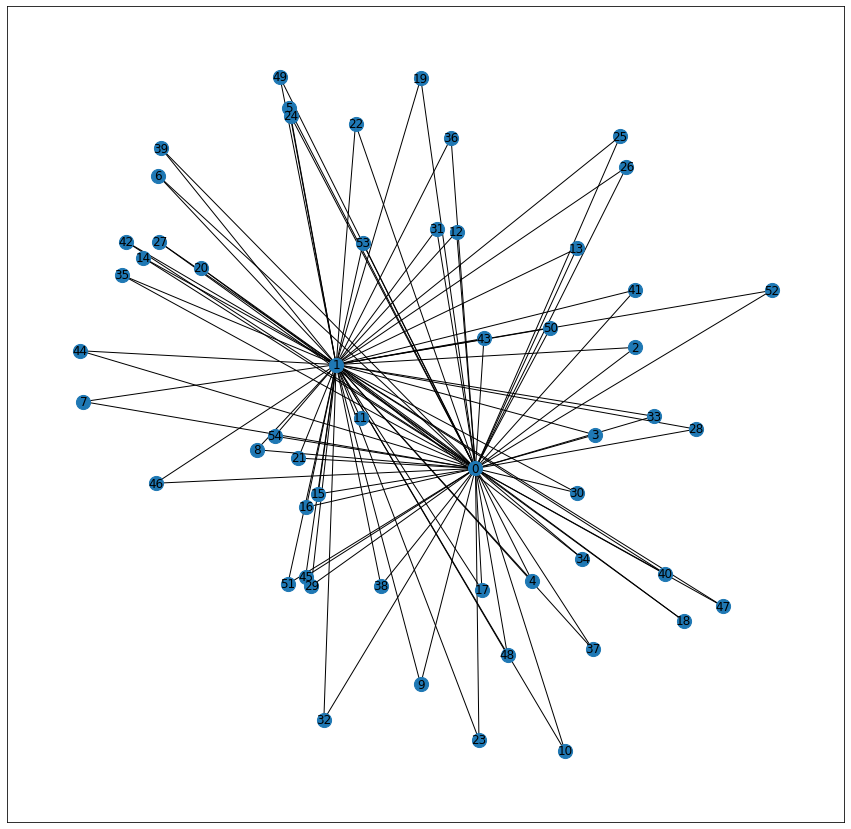

In [30]:
codeStart = filtreDictAeroports('Name', airportArrive.value)[0]
codeEnd = filtreDictAeroports('Name', airportDepart.value)[0] 

graph_widget, list_ref = traitementRequest(airportArrive.value, airportDepart.value)

if( graph_widget.number_of_nodes() > 0):
    dessinerGraphe(graph_widget)

else : print('On n\'a pas trouve une correspondance')

In [31]:
recommandationSelon

RadioButtons(description='Recommendation selon : ', index=2, options=('alternatives', 'distance', 'direct'), v…

In [79]:
if(recommandationSelon.value == 'direct'): 
    tmp = df_vols[df_vols['Depart'] == codeStart]
    tmp2 = tmp[tmp['Arrivee'] == codeEnd] ; 
    
    D = tmp2['Depart'].to_list()
    A = tmp2['Arrivee'].to_list()
    
    list_resultat = []
    for i in range(len(tmp2)):
        list_resultat.append([D[i], A[i]])
    
    if len(list_resultat) > 0 :
        print(' il y a une vol direct ')
        print([list_resultat[0]])
        #map_correspondance([list_resultat[0]])
    else: print('il n\'y pas une vol direct, essayez une autre option') ; display(recommandationSelon);

if(recommandationSelon.value == 'distance'): 
    resultat = distancePlusCourte(graph_widget, list_ref, codeStart, codeEnd) 
    #print(resultat)
    map_correspondance([resultat['path']])
    
if(recommandationSelon.value == 'alternatives'): 
   resultat =  routeAlternatives(graph_widget, list_ref, list_ref.index(codeStart), list_ref.index(codeEnd))
   #print(resultat)
   map_correspondance(resultat['path'])
    

In [33]:
nombreCorrespondance1

IntSlider(value=3, continuous_update=False, description='Nombre de correspondances :', max=10, min=3)

In [63]:
# ces calculations sont tres couteux et pouvait seulement entre fait si on a une petit graphe 
if graph_widget.number_of_nodes() < 200 or graph_widget.number_of_edges() < 1000 :
    print('c\' est un graphe petit donc on peut se permettre de donnee plus de details : ')
    resultat2 = routeSelonNombreCorrespondanceLessThen(graph_widget, nombreCorrespondance1.value, list_ref.index(codeStart) , list_ref.index(codeEnd))
    if not(resultat2 == {}):
        tmp_correspondances = []
        for p in resultat2['path']: 
            tmp_correspondances.append(list(map(lambda x : list_ref[x], p)))
        
        resultat2['path'] = tmp_correspondances

        map_correspondance(resultat2['path'])
    else : print('le nombre est trop petit')

c' est un graphe petit donc on peut se permettre de donnee plus de details : 


# New Idea 

l'idea est de cree un graphe en totale de tous les routes 

comment l'utilise : 
- install voila 
- execute ces commandes :   jupyter serverextension enable voila
                            jupyter server extension enable voila

- lance le notebook avec:  jupyter notebook
- trouve le localhost du jupyter notebook
- localhost888/voila <-- ce commande donne le voila dashboard>


In [3]:
import markupsafe 
from base64 import encodestring

ImportError: cannot import name 'encodestring' from 'base64' (C:\Users\Merel\AppData\Local\Programs\Python\Python39\lib\base64.py)

In [35]:
graph_totale = nx.Graph()
list_airports_codes = []; 

compteur = 0 
list_debug = [] 
for key in dict_route:

    if len(key) == 2 :
        start, end = key 
        compteur = compteur + 1
        
        if list_airports_codes.count(start) == 0:
            list_airports_codes.append(start)

        if list_airports_codes.count(end) == 0:
            list_airports_codes.append(end)
            
        index_start = list_airports_codes.index(start); 
        index_end = list_airports_codes.index(end); 
        distance = dict_route[frozenset((start,end))]['Dist']
        
        graph_totale.add_node(index_start)
        graph_totale.add_node(index_end)
        
        graph_totale.add_edge(index_start, index_end, weight = distance)
    else: list_debug.append(key)

nb_keys = len(dict_route.keys())
print('Nombre de keys dans le dict_route : ', print(nb_keys))
debug = nb_keys - compteur
print('Nombre de keys qui ne sont pas ajoute : ', debug , ', voici le tableau avec le keys qui ne sont pas ajoutee')
#print(list_debug)

24792
Nombre de keys dans le dict_route :  None
Nombre de keys qui ne sont pas ajoute :  114 , voici le tableau avec le keys qui ne sont pas ajoutee


In [36]:
def supprimerJusqauNombre(g_modif : nx.Graph, nombre : int, index1 , index2):
    
    index_compteur = 0 
    collection_solutions = dict() 
    
    solution = dijkstra(g_modif, index1, index2)
    collection_solutions[index_compteur] = solution; 
    
    memoire = []
    
    while(len(solution['path']) < nombre ):
        
        ###################################
        for i in range(len(solution['path'])-1) :
            w = g_modif.get_edge_data(solution['path'][i], solution['path'][i+1])['weight']
            memoire.append([solution['path'][i], solution['path'][i+1], w])
            
            # delete les paths le plus vite --> on trouve les autres paths plus vite 
            g_modif.remove_edge(solution['path'][i], solution['path'][i+1])
        
        ###################################
        # trouve la nouvelle solution 
        solution = dijkstra(g_modif, index1, index2)
        # ajouter la solution au dict de resultat 
        collection_solutions[index_compteur] = solution
        # augementer le compteur ( qui fonctionne comme cle dans le dict)
        index_compteur = index_compteur + 1 

    
    # remettre le graph au graph originale 
    g_modif.add_weighted_edges_from(memoire)
    
    return collection_solutions    

In [37]:
def plus_courte(index1, index2, airport1, airport2): 
    if graph_totale.has_node(index1):
        if graph_totale.has_node(index2):
            
            ###################### plus courtes ###########################
            resultat = dijkstra(graph_totale, index1, index2)
            
            s = list(map(lambda x : list_airports_codes[x], resultat['path']))
            solution_plus_courte = dict(); 
            solution_plus_courte[0] = {'distance' : resultat['distance'], 'path' : s }
            #print(solution_plus_courte)
            map_correspondance(solution_plus_courte)
        else : print(airport1, ' n\'est pas presente dans le graphe')
    else : print(airport2, ' n\'est pas presente dans le graphe')

In [38]:
def differents_longeurs(index1, index2, airport1, airport2, list_nombre):
    if graph_totale.has_node(index1):
        if graph_totale.has_node(index2):
            
            int_s , int_e = list_nombre 
            int_s = int(int_s)
            int_e = int(int_e)
            ###################### differentes longeurs ###################
            collection_solution = supprimerJusqauNombre(graph_totale, int_e, index1, index2)
            
            new_collection_solution = dict() 
            c = 0 
            for key, contenu in collection_solution.items():
                
                if len(contenu['path']) <= int_e and len(contenu['path']) >= int_s : 
                    tmp = []
                    for x in contenu['path'] :
                        tmp.append(list_airports_codes[x])
                    
                    new_collection_solution[c] = {'distance' : contenu['distance'], 'path' :tmp}  
                    c = c + 1 
        
            #print('Collection : ', new_collection_solution)
            
            map_correspondance(new_collection_solution)    
            
        else : print(airport1, ' n\'est pas presente dans le graphe')
    else : print(airport2, ' n\'est pas presente dans le graphe')

In [108]:
a = airportArrive
b = airportDepart
d = nombreCorrespondance
ui = widgets.HBox([a, b, d])
def f(a, b, d):
    print(a,"/",b,"/", d)
    

out = widgets.interactive_output(f, {'a' : a , 'b': b, 'd' : d})

display(ui, out)

Output()

In [101]:
def response_widget(nom1, nom2, nombre):
    
    airport1 = filtreDictAeroports('Name', nom1)[0]
    airport2 = filtreDictAeroports('Name', nom2)[0] 


    if not(list_airports_codes.count(airport1) == 0) : 
        index1 = list_airports_codes.index(airport1)
    else : print(airportArrive.value, 'n\'est pas dans le graphe')
    if not(list_airports_codes.count(airport2) == 0) : index2 = list_airports_codes.index(airport2)   
    else : print(airportDepart.value, 'n\'est pas dans le graphe') 

    plus_courte(index1, index2, airport1, airport2)
    print(' ')
    differents_longeurs(index1, index2, airport1, airport2, nombre)

In [107]:
str_output = out.outputs[0]['text']
x = str_output.split(" / ")

nomAirport1 = x[0]
nomAirport2 = x[1]
tmp_range = x[2].strip('\n').strip('( )').split(',')


#response_widget(nomAirport1, nomAirport2, tmp_range)

In [114]:
lanceFonction = tkinter.Tk()

button = widgets.Button(description = 'submit')
output = widgets.Output()
display(button, output)

def bouton():
    with output: 
        response_widget(airportDepart.value, airportArrive.value , nombreCorrespondance.value)

button.on_click(bouton)

Button(description='submit', style=ButtonStyle())

Output()